## Mixture Density Networks (Gaussian Mixture) for inverted sinusoidal function

### 0. Global seeding

In [66]:
from lagom import set_global_seeds

set_global_seeds(seed=0)

### 1. Data generation

In [67]:
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader


class Data(Dataset):
    r"""Generate a set of data point of an inverted sinusoidal function. 
    i.e. y(x) = 7sin(0.75x) + 0.5x + eps, eps~N(0, 1)
    
    Then we ask the neural networks to predict x given y, in __getitem__(). 
    In this case, the classic NN suffers due to only one output given input. 
    To address it, one can use Mixture Density Networks. 
    """
    def __init__(self, n):
        self.n = n
        self.x, self.y = self._generate_data(self.n)
    
    def _generate_data(self, n):
        eps = np.random.randn(n)
        x = np.random.uniform(low=-10.5, high=10.5, size=n)
        y = 7*np.sin(0.75*x) + 0.5*x + eps
        
        return np.float32(x), np.float32(y)  # Enforce the dtype to be float32, i.e. FloatTensor in PyTorch
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        # Retrieve the x, y value
        x = self.x[index]
        y = self.y[index]
        # Keep array shape due to scalar value
        x = np.array([x], dtype=np.float32)
        y = np.array([y], dtype=np.float32)

        return y, x

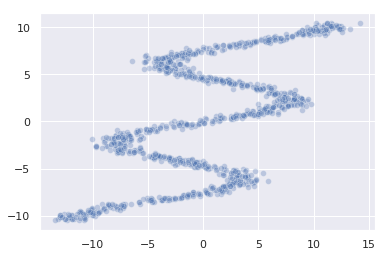

In [68]:
import seaborn as sns
sns.set()

data = Data(n=1000)
sns.scatterplot(data.y, data.x, alpha=0.3)

### 2. Make MDN network

In [69]:
import torch.nn as nn

from lagom.core.networks import make_fc
from lagom.core.networks import ortho_init

from lagom.core.networks import BaseMDN


class MDN(BaseMDN):
    def make_feature_layers(self, config):
        out = make_fc(input_dim=1, hidden_sizes=[15, 15])
        last_dim = 15
        
        return out, last_dim
        
    def make_mdn_heads(self, config, last_dim):
        out = {}
        
        num_density = 20
        data_dim = 1
        
        out['unnormalized_pi_head'] = nn.Linear(in_features=last_dim, out_features=num_density*data_dim)
        out['mu_head'] = nn.Linear(in_features=last_dim, out_features=num_density*data_dim)
        out['logvar_head'] = nn.Linear(in_features=last_dim, out_features=num_density*data_dim)
        out['num_density'] = num_density
        out['data_dim'] = data_dim
        
        return out
        
    def init_params(self, config):
        for layer in self.feature_layers:
            ortho_init(layer, nonlinearity='tanh', constant_bias=0.0)
        
        ortho_init(self.unnormalized_pi_head, nonlinearity=None, weight_scale=0.01, constant_bias=0.0)
        ortho_init(self.mu_head, nonlinearity=None, weight_scale=0.01, constant_bias=0.0)
        ortho_init(self.logvar_head, nonlinearity=None, weight_scale=0.01, constant_bias=0.0)
        
    def feature_forward(self, x):
        for layer in self.feature_layers:
            x = torch.tanh(layer(x))
            
        return x

### 2. Training

In [70]:
import torch.optim as optim

D = Data(n=2500)
train_loader = DataLoader(D, batch_size=64)

device = torch.device('cuda')
model = MDN()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=5e-3)

for i in range(1000):
    model.train()
    
    losses = []
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        log_pi, mu, std = model(data)
        loss = model.MDN_loss(log_pi=log_pi, 
                              mu=mu, 
                              std=std, 
                              target=target)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        
    if i == 0 or (i+1)%100 == 0:
        #IPython.display.clear_output(wait=True)
        print(f'Epoch: {i+1}\t Loss: {np.mean(losses)}')

Epoch: 1	 Loss: 8.450447303056716
Epoch: 100	 Loss: 1.4235985428094864
Epoch: 200	 Loss: 1.3789412468671798
Epoch: 300	 Loss: 1.3592249304056168
Epoch: 400	 Loss: 1.3541212648153305
Epoch: 500	 Loss: 1.3498706758022307
Epoch: 600	 Loss: 1.3428360730409623
Epoch: 700	 Loss: 1.3417653858661651
Epoch: 800	 Loss: 1.3406617403030396
Epoch: 900	 Loss: 1.426487547159195
Epoch: 1000	 Loss: 1.3438463136553764


### 3. Evaluation

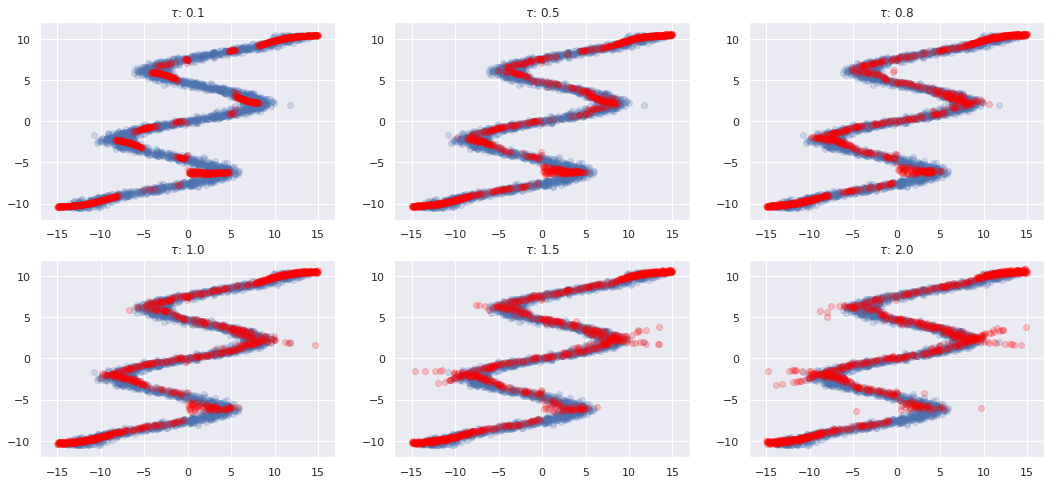

In [71]:
import matplotlib.pyplot as plt
sns.set()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6*3, 4*2))

# Temperature: controls the uncertainty. 
# Larger temperature leads to larger uncertainty. 
list_tau = [0.1, 0.5, 0.8, 1.0, 1.5, 2.0]

test_data = torch.tensor(np.linspace(-15, 15, num=1000, dtype=np.float32), device=device).unsqueeze(1)

with torch.no_grad():  # disable gradient computation, save memory
    model.eval()  # evaluation mode
    
    log_pi, mu, std = model(test_data.to(device))

    for tau, ax in zip(list_tau, axes.reshape(-1)):
        samples = model.sample(log_pi=log_pi, mu=mu, std=std, tau=tau, _fast_code=True)
        samples.detach().cpu().numpy()

        ax.scatter(D.y, D.x, alpha=0.2)
        ax.scatter(test_data.detach().cpu().numpy(), samples.detach().cpu().numpy(), alpha=0.2, color='red')

        offset = 2
        ax.set_xlim(-15 - offset, 15 + offset)
        ax.set_ylim(-10 - offset, 10 + offset)
        
        ax.set_title(r'$\tau$: ' + str(tau))
    
#fig.savefig('samples.png')
#fig